# Previsão de Chuva - Classificação (Abordagem 1)

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')
import seaborn as sns

In [ ]:
import sys
import os

# Adicionar src/ ao path do Python
sys.path.append(os.path.abspath('../src'))

# Agora o import funciona
from data_prep import prep_data

# 1 - Processamento de Dados

## 1.1 - Criação dos Dataframes
Função que faz todo o tratamento dos arquivos de entrada e gera dois Dataframes, um com os dados de entrada, e outro com os dados de saída.\
Código completo no arquivo `data_prep.py`

In [2]:
df_in, df_out = prep_data()

## 1.2 - Abordagem 1: Separação em Quadrimestres
Reorganizamos os dataframes em Quadrimestres em vez de Meses, agregando os dados.\
Nessa abordagem, usamos a média (`mean`) dos atributos de entrada, e a soma (`sum`) da precipitação total.

In [3]:
# Criar cópias dos dataframes originais para evitar modificações diretas
df_in_copy = df_in.copy()
df_out_copy = df_out.copy()

# Função para identificar o quadrimestre
def assign_quad(month):
    if month in [1, 2, 3, 4]:
        return 1
    elif month in [5, 6, 7, 8]:
        return 2
    elif month in [9, 10, 11, 12]:
        return 3

# Adicionar a coluna de quadrimestre
df_in_copy['QUAD'] = df_in_copy['MON'].apply(assign_quad)
df_out_copy['QUAD'] = df_out_copy['MON'].apply(assign_quad)

# Filtrar os dados de entrada e saída para incluir apenas anos de 1982 a 2023
df_in_copy = df_in_copy[(df_in_copy['YEAR'] >= 1982) & (df_in_copy['YEAR'] <= 2023)]
df_out_copy = df_out_copy[(df_out_copy['YEAR'] >= 1982) & (df_out_copy['YEAR'] <= 2023)]

# Agregar dados de entrada por quadrimestre
aggregated_in = df_in_copy.groupby(['YEAR', 'QUAD']).agg({
    '1_TW_CP': 'mean',
    '2_DarwinPr': 'mean',
    '3_TW_EP': 'mean',
    '4_TahitiPr': 'mean',
    '5_TW_WP': 'mean',
    '6_NATL': 'mean',
    '6_SATL': 'mean',
    '6_TROP': 'mean',
    '7_NINO1+2': 'mean',
    '7_NINO3': 'mean',
    '7_NINO4': 'mean',
    '7_NINO3.4': 'mean'
}).reset_index()

# Agregar precipitação por quadrimestre (total acumulada)
aggregated_out = df_out_copy.groupby(['YEAR', 'QUAD']).agg({
    'PRECIP': 'sum'  # Soma da precipitação para o quadrimestre
}).reset_index()

# Mesclar os dados de entrada e saída agregados
aggregated_data = pd.merge(aggregated_in, aggregated_out, on=['YEAR', 'QUAD'])

# Exibir o dataframe resultante
#aggregated_data

# 2 - Códigos de Preparação

## 2.1 - Definição das Classses

In [4]:
# Calcular a mediana da precipitação
median_precip = aggregated_data['PRECIP'].median()

# Criar uma função para classificar a precipitação
def classify_precipitation(precip):
    if precip <= median_precip:
        return 'Baixa Precipitação'
    else:
        return 'Alta Precipitação'

# Aplicar a função para criar a nova coluna de classe
aggregated_data['Precip_Class'] = aggregated_data['PRECIP'].apply(classify_precipitation)

# Converter rótulos para 0 e 1
label_mapping = {'Baixa Precipitação': 0, 'Alta Precipitação': 1}
aggregated_data['Precip_Class'] = aggregated_data['Precip_Class'].map(label_mapping)

# Exibir o dataframe resultante
#aggregated_data

## 2.2 - Lista de Modelos

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

lista_modelos = [
    # =========================================================
    # 1. Random Forest
    # =========================================================
    {
        "nome_do_modelo": "Random Forest",
        "estimador": Pipeline([
            ('scaler', StandardScaler()), 
            ('pca', PCA()),
            ('classifier', RandomForestClassifier(random_state=42))
        ]),
        "parametros": {
            'pca__n_components': [2, 3, 4],          # Componentes do PCA
            'classifier__n_estimators': [50, 100],   # Número de árvores
            'classifier__max_depth': [None, 10, 20], # Profundidade máxima
            'classifier__min_samples_split': [2, 5]  # Divisão mínima
        }
    },

    # =========================================================
    # 2. Regressão Logística
    # =========================================================
    {
        "nome_do_modelo": "Logistic Regression",
        "estimador": Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('classifier', LogisticRegression(max_iter=1000, random_state=42))
        ]),
        "parametros": {
            'pca__n_components': [2, 3],             
            'classifier__C': [0.1, 1, 10],           # Regularização
            'classifier__penalty': ['l2', 'l1'],     
            'classifier__solver': ['liblinear']       # Solver compatível com L1/L2
        }
    },

    # =========================================================
    # 3. MLP (Multi-Layer Perceptron)
    # =========================================================
    {
        "nome_do_modelo": "MLP",
        "estimador": Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('classifier', MLPClassifier(random_state=42, early_stopping=True))
        ]),
        "parametros": {
            'pca__n_components': [3, 4],             
            'classifier__hidden_layer_sizes': [(50,), (100,)], # Camadas ocultas
            'classifier__activation': ['relu', 'tanh'], 
            'classifier__alpha': [0.0001, 0.001]     # Regularização L2
        }
    },

    # =========================================================
    # 4. KNN (K-Nearest Neighbors)
    # =========================================================
    {
        "nome_do_modelo": "KNN",
        "estimador": Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('classifier', KNeighborsClassifier())
        ]),
        "parametros": {
            'pca__n_components': [2, 3],             
            'classifier__n_neighbors': [3, 5, 7],    # Número de vizinhos
            'classifier__weights': ['uniform', 'distance'] 
        }
    },

    # =========================================================
    # 5. SVM (Support Vector Machine)
    # =========================================================
    {
        "nome_do_modelo": "SVM",
        "estimador": Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('classifier', SVC(random_state=42, probability=True)) # probability=True para ROC
        ]),
        "parametros": {
            'pca__n_components': [2, 3],             
            'classifier__C': [0.1, 1, 10],           # Penalidade de erro
            'classifier__kernel': ['rbf', 'linear'], 
            'classifier__gamma': ['scale', 'auto']   
        }
    }
]

# 3 - Treinamento




 **** RESULTADO DOS MODELOS + CURVAS ROC E PR ****

....nando modelo Random Forest .
-- coletando e armazenando resultados --

 - Acurácia   : 0.9046 +/- 0.06516
 - Precisão   : 0.9053 +/- 0.05328
 - Revocação  : 0.9026 +/- 0.12286
 - F1 - Score : 0.8994 +/- 0.07779
 - ROC - AUC  : 0.9747 +/- 0.02373
 - PR - AUC   : 0.9716 +/- 0.03193
 - Tempo médio de treinamento: 4.04 segundos


...inando modelo Logistic Regression ..
-- coletando e armazenando resultados --

 - Acurácia   : 0.8169 +/- 0.06087
 - Precisão   : 0.8376 +/- 0.10623
 - Revocação  : 0.8256 +/- 0.12426
 - F1 - Score : 0.8175 +/- 0.05511
 - ROC - AUC  : 0.9401 +/- 0.03495
 - PR - AUC   : 0.9384 +/- 0.04266
 - Tempo médio de treinamento: 0.12 segundos


....nando modelo MLP .
-- coletando e armazenando resultados --

 - Acurácia   : 0.7138 +/- 0.07878
 - Precisão   : 0.6512 +/- 0.06090
 - Revocação  : 0.9667 +/- 0.06667
 - F1 - Score : 0.7742 +/- 0.04018
 - ROC - AUC  : 0.7798 +/- 0.09989
 - PR - AUC   : 0.7438 +/- 0.10269

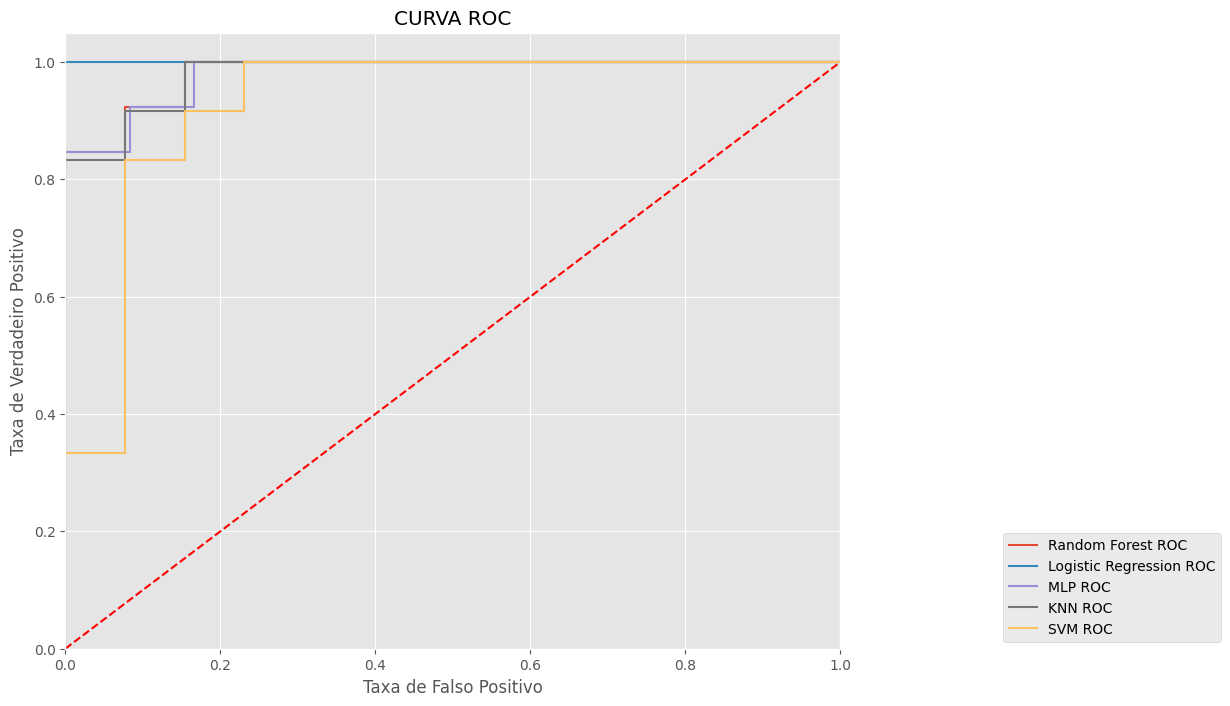

In [6]:
from classification_train_util import nested_cross_validation_grid_search

# Separar features e target
X = aggregated_data.drop(columns=['Precip_Class', 'YEAR', 'QUAD'])
y = aggregated_data['Precip_Class']

# Chamar a função de validação cruzada com os dados processados
resultados_gerais = nested_cross_validation_grid_search(
    lista_modelos=lista_modelos,
    X=X,
    y=y,
    k_folds_outer=5,
    k_folds_inner=3
)

# 4 - Resultados

In [7]:
# Converter os resultados para DataFrame
df_resultados = pd.DataFrame(resultados_gerais).T.reset_index()
df_resultados = df_resultados.rename(columns={'index': 'Modelo'})

# Selecionar colunas relevantes
colunas = ['Modelo', 'F1_score_mean', 'Acurácia_mean', 'aucROC_mean', 'aucPR_mean']
df_comparacao = df_resultados[colunas]

# Ordenar pelo F1-score (métrica principal)
df_comparacao = df_comparacao.sort_values('F1_score_mean', ascending=False)

print(df_comparacao)

                Modelo F1_score_mean Acurácia_mean aucROC_mean aucPR_mean
0        Random Forest      0.899389      0.904615    0.974655   0.971588
4                  SVM      0.841991      0.840923    0.933925   0.927365
1  Logistic Regression      0.817519      0.816923    0.940138   0.938438
3                  KNN      0.806462      0.809538    0.920168   0.884149
2                  MLP      0.774225      0.713846    0.779783   0.743822


<Figure size 1000x600 with 0 Axes>

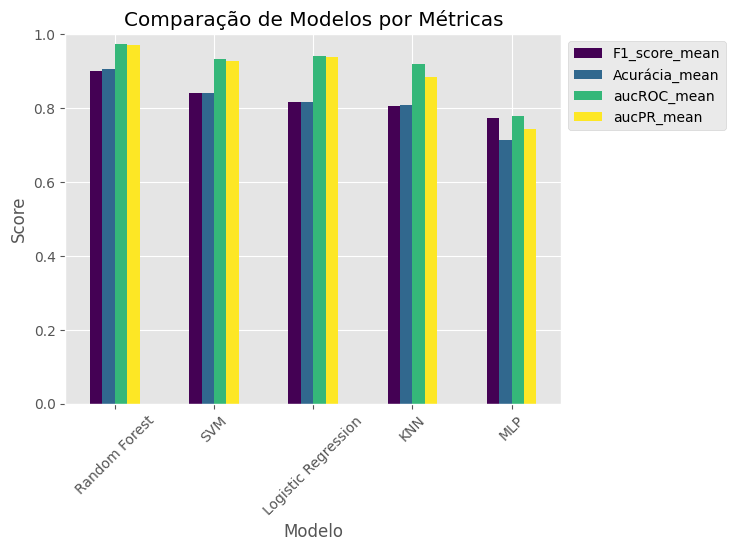

In [8]:
# Configurar o gráfico
plt.figure(figsize=(10, 6))
df_comparacao.set_index('Modelo').plot(kind='bar', rot=45, colormap='viridis')
plt.title('Comparação de Modelos por Métricas')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [9]:
# Pegar o melhor modelo com base no F1-score
melhor_modelo = df_comparacao.iloc[0]['Modelo']
melhor_f1 = df_comparacao.iloc[0]['F1_score_mean']
melhores_parametros = resultados_gerais[melhor_modelo]['melhores_parametros'][0]

# Imprimir em formato amigável
print(f"\n=== MELHOR MODELO ===")
print(f"Nome: {melhor_modelo}")
print(f"F1-Score Médio: {melhor_f1:.2f}")
print("\nParâmetros Otimizados:")
for parametro, valor in melhores_parametros.items():
    print(f" - {parametro}: {valor}")


=== MELHOR MODELO ===
Nome: Random Forest
F1-Score Médio: 0.90

Parâmetros Otimizados:
 - classifier__max_depth: None
 - classifier__min_samples_split: 5
 - classifier__n_estimators: 50
 - pca__n_components: 4
